# 2. Data exploration

In [73]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

import data_support as sup
import scp.plots as pl
import scp.utils as utils
import scp.metrics as metrics

np.random.seed(0)

Let"s define the paths.

In [14]:
MAIN_DIR = "../../data/manns_lab/MAIN/"
PILOT_DIR = "../../data/manns_lab/PILOT/"

Let"s load the data.

In [15]:
adata = sup.load_data(MAIN_DIR, PILOT_DIR, do_batch_correction=True, integrate=True)

preprocess input: (4566, 2703)
sc.pp.filter_genes: (4566, 2703)
sc.pp.filter_cells: (4566, 2703)
filter: (4566, 2018)
preprocess input: (454, 3306)
sc.pp.filter_genes: (454, 3305)
sc.pp.filter_cells: (454, 3305)
filter: (454, 2963)


/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rasmus/sollertis/school/s11/thesis/MS_mv_modelling/notebooks/manns_inhouse/data_support.py:312: RuntimeWarning: Mean of empty slice
  mean_protein_per_plate = np.nanmean(x, axis=0)


transfering 447 cells and 1783 proteins during reshape.

main intensity coverage:     69.66%
pilot intensity coverage:    7.47%
combined intensity coverage: 71.28%


After filtering the data, we end up with:

In [16]:
adata

AnnData object with n_obs × n_vars = 4566 × 2018
    obs: 'Run', 'Experiment', 'Sex', 'Age', 'MSgroup', 'Diagnosis_group', 'Diagnosis_group_subtype', 'Diagnosis_group_autoimmune_split', 'RMS_PMS', 'Plate', 'Preparation day', 'Sample_position', 'Sample_row', 'Sample_column', 'Leukocyte count', 'Leukocyte_count_log2', 'Erythrocytes', 'Total protein', 'Total_protein_log2', 'Albumin CSF', 'Albumin_CSF_log2', 'Qalb', 'QAlb_log2', 'Diff_age_adj_QAlb', 'Diff_age_adj_QAlb_log2', 'IgG CSF', 'IgG_CSF_log2', 'QIgG', 'QIgG_log2', 'Sample_injection_number', 'Sample_injection_order', 'Sample_plate_order', 'Sample_plate_order_inCrossSectional', 'Depth_PG', 'Depth_Gene', 'EvoSep', 'LC_column', 'Emitter', 'Capillary', 'MS_calibration', 'Evosept', 'Column', 'Maintenance', 'log Qalb', 'File.Name', 'Precursors.Identified', 'Proteins.Identified', 'Total.Quantity', 'MS1.Signal', 'MS2.Signal', 'FWHM.Scans', 'FWHM.RT', 'Median.Mass.Acc.MS1', 'Median.Mass.Acc.MS1.Corrected', 'Median.Mass.Acc.MS2', 'Median.Mass

Proteins with no missing values in main: 10.51%


In the intensity-based expression matrix, each obs is a patient and each "var" is a protein.


**Interesting patient specific attributes:**
* Diagnosis_group: the diagnosis of the patient
* Qalb  and IgG CSF: Serum quotient of albumin (Qalb) and the cerebrospinal fluid (CSF) are the most used biomarker for the evaluation of blood–cerebrospinal fluid barrier (B-CSF-B) permeability. They are age- and sex-related.

In [5]:
adata.obs.head()

,Run,Experiment,Sex,Age,MSgroup,Diagnosis_group,Diagnosis_group_subtype,Diagnosis_group_autoimmune_split,RMS_PMS,Plate,...,Median.Mass.Acc.MS1.Corrected,Median.Mass.Acc.MS2,Median.Mass.Acc.MS2.Corrected,MS2.Mass.Instability,Normalisation.Instability,Median.RT.Prediction.Acc,Average.Peptide.Length,Average.Peptide.Charge,Average.Missed.Tryptic.Cleavages,n_genes
ID,,,,,,,,,,,,,,,,,,,,,
01_A_03,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,F,24.0,nonMS,Headache,NaN,Headache,NaN,plate1,...,1.87526,3.90571,2.57315,0,0.161620,0.026961,13.827,2.341,0.168,1601
01_A_04,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,53.0,nonMS,Neurodegenerative,NaN,Neurodegenerative,NaN,plate1,...,1.84340,3.77452,2.65587,0,0.246424,0.027870,13.820,2.340,0.173,1694
01_A_05,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,55.0,nonMS,Other,NaN,Other,NaN,plate1,...,1.78942,3.41259,2.42294,0,0.084540,0.029365,14.330,2.391,0.212,1516
01_A_06,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,33.0,nonMS,Other,NaN,Other,NaN,plate1,...,1.82053,3.38577,2.51288,0,0.138253,0.029304,14.312,2.388,0.196,1572
01_A_07,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,F,26.0,MS,MS,RMS,MS,RMS,plate1,...,1.82249,3.43340,2.55149,0,0.226453,0.032779,13.588,2.335,0.174,1521


Let's look at main.

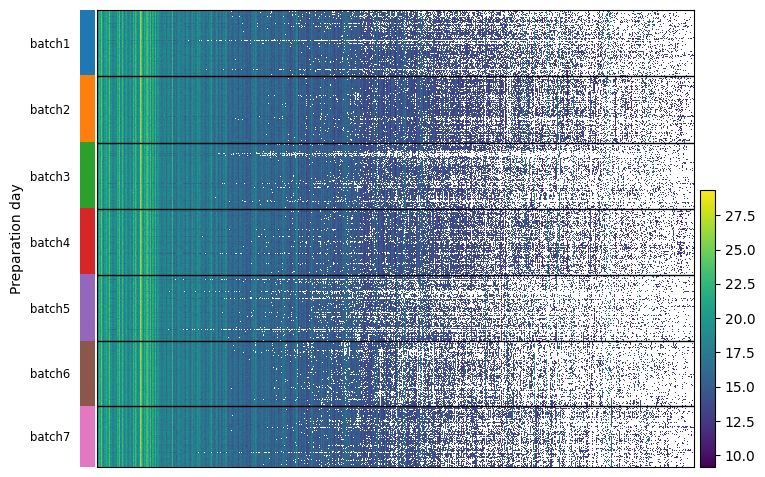

In [17]:
adata = utils.sort_anndata_by_missingness(adata, layer="main")
sc.pl.heatmap(adata, layer="main", var_names=adata.var_names, groupby="Preparation day", show_gene_labels=False)

In [20]:
protein_missingness = utils.get_missingness_per_protein(adata, layer="main")
print(f"Proteins with no missing values in main: {np.sum(protein_missingness == 0) / len(protein_missingness) * 100:.2f}%")

Proteins with no missing values in main: 10.51%


Let's look at pilot.

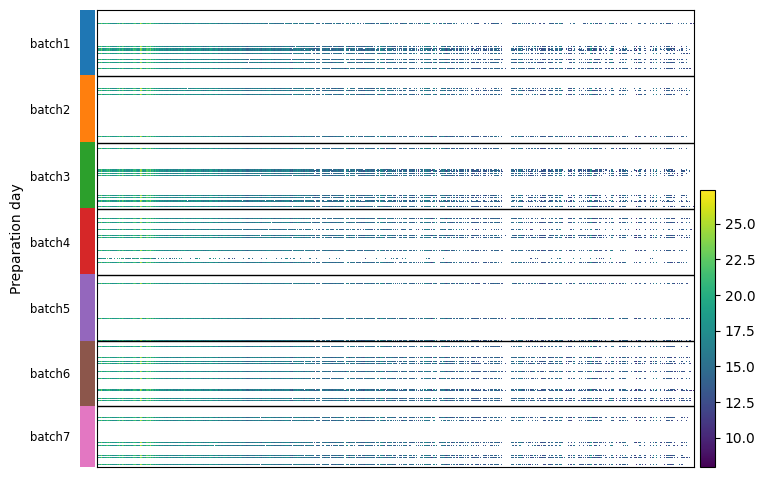

In [7]:
sc.pl.heatmap(adata, layer="pilot", var_names=adata.var_names, groupby="Preparation day", show_gene_labels=False)

Let's plot average protein intensities of the proteins with intensities in both main and pilot.

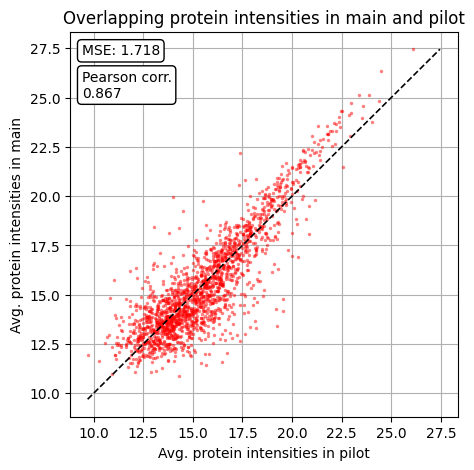

In [33]:
sup.scatter_pilot_main_by_protein(adata.layers["main"], adata.layers["pilot"])

Let's plot average protein intensities of the proteins with intensities in both main and pilot again. This time we also filter by how correlated the intensities are within each protein between pilot and main.

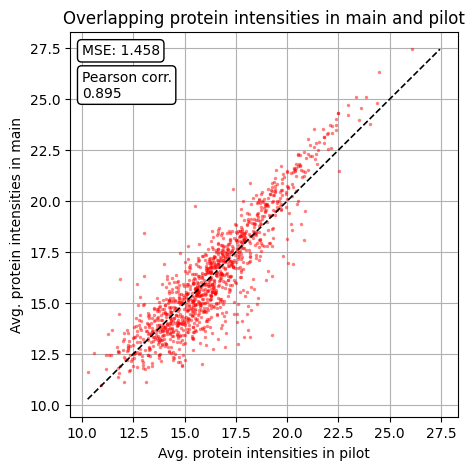

In [68]:
min_correlation = 0.3

corrs = metrics.compare_intensities_protein_wise(adata.layers["main"], adata.layers["pilot"])

adata2 = adata[:, corrs["protein_idx"]]
adata2 = adata2[:, np.array(corrs["pearson"]) > min_correlation]

sup.scatter_pilot_main_by_protein(adata2.layers["main"], adata2.layers["pilot"])

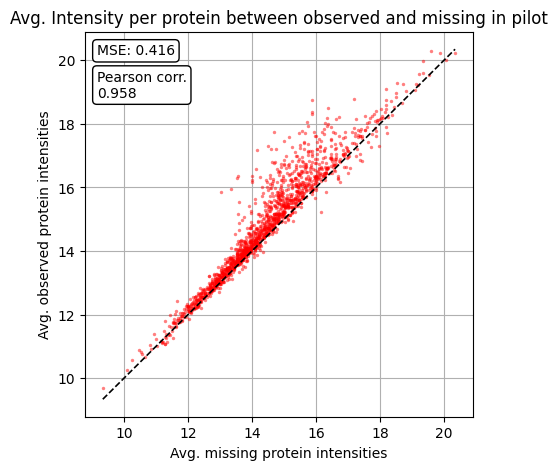

In [69]:
sup.scatter_pilot_pilot_by_protein(adata.layers["main"], adata.layers["pilot"])

Let"s look at the distribution of some of the patient features.

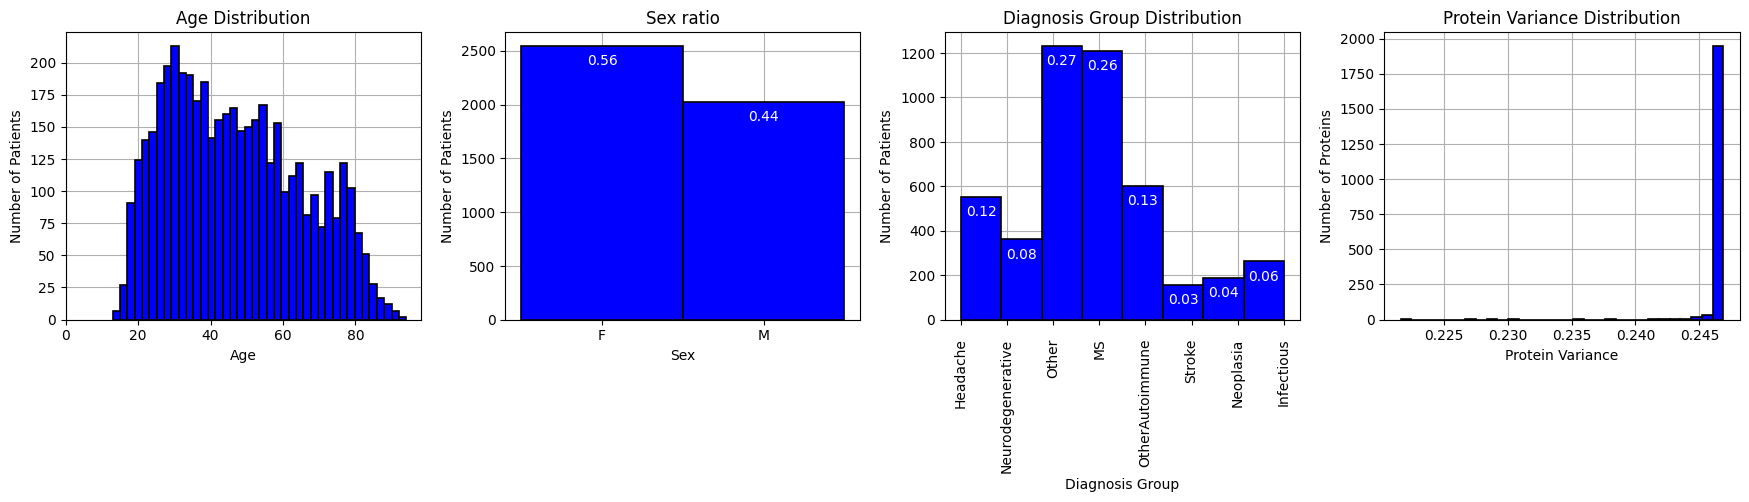

In [71]:
fig, axes = plt.subplots(figsize=(18, 4), nrows=1, ncols=4)
fig.tight_layout(pad=3.0)

# age
ax = axes[0]
ax.hist(adata.obs["Age"], bins=40, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Age")
ax.set_ylabel("Number of Patients")
ax.set_title("Age Distribution")
ax.set_xlim([0, None])
ax.grid(True)
ax.set_axisbelow(True)

# sex
ax = axes[1]
ax.hist(adata.obs["Sex"], bins=2, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Sex")
ax.set_ylabel("Number of Patients")
ax.set_title("Sex ratio")
ax.set_xticks([0.25, 0.75])
ax.grid(True)
ax.set_axisbelow(True)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 200, f"{height / len(adata.obs):.2f}", ha="center", va="bottom", color="white")

# diagnosis group
ax = axes[2]
n_bins = len(adata.obs["Diagnosis_group"].unique())
ax.hist(adata.obs["Diagnosis_group"], bins=n_bins, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Diagnosis Group")
ax.set_ylabel("Number of Patients")
ax.set_title("Diagnosis Group Distribution")

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 100, f"{height / len(adata.obs):.2f}", ha="center", va="bottom", color="white")

ax.tick_params(axis="x", pad=10)
ax.grid(True)
ax.set_axisbelow(True)

# histogram of protein variances
ax = axes[3]

x = adata.layers["main"]
protein_variance = np.nanvar(x, axis=0)
ax.hist(protein_variance, bins=30, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Protein Variance")
ax.set_ylabel("Number of Proteins")
ax.set_title("Protein Variance Distribution")
ax.grid(True)
ax.set_axisbelow(True)

The biomarkers are age related. Let's see if that is also true for this dataset.

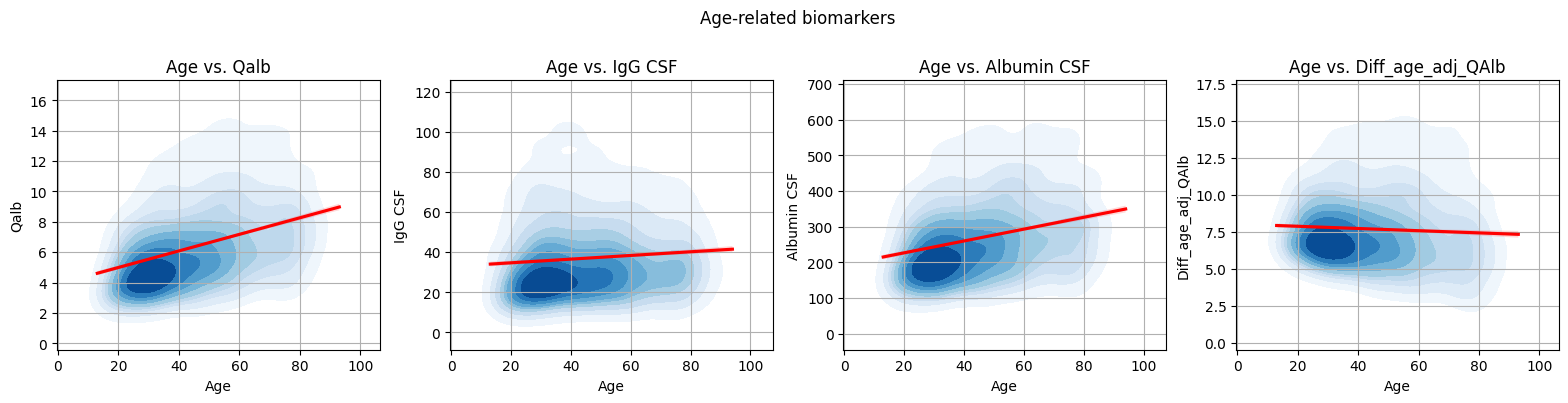

In [72]:
biomarkers = ["Qalb", "IgG CSF", "Albumin CSF", "Diff_age_adj_QAlb"]

n_cols = len(biomarkers)

fig, axes = plt.subplots(ncols=n_cols, nrows=1, figsize=(16, 4))
fig.suptitle("Age-related biomarkers")
fig.tight_layout(pad=2.0)

for i, biomarker in enumerate(biomarkers):
    biomarker_sub = adata[adata.obs[biomarker] < adata.obs[biomarker].quantile(0.95), :]
    
    ax = axes[i]
    #ax.scatter(x=subset.obs["Age"], y=subset.obs[biomarker], color="blue", alpha=1, s=1)
    sns.kdeplot(x=biomarker_sub.obs["Age"], y=biomarker_sub.obs[biomarker], cmap="Blues", shade=True, shade_lowest=False, ax=ax)
    sns.regplot(x=biomarker_sub.obs["Age"], y=biomarker_sub.obs[biomarker], ax=ax, scatter=False, color="red")
    ax.set_xlabel("Age")
    ax.set_ylabel(biomarker)
    ax.set_title("Age vs. {}".format(biomarker))
    ax.grid(True)

Let's check if Qalb and intensity missingess is correlated.

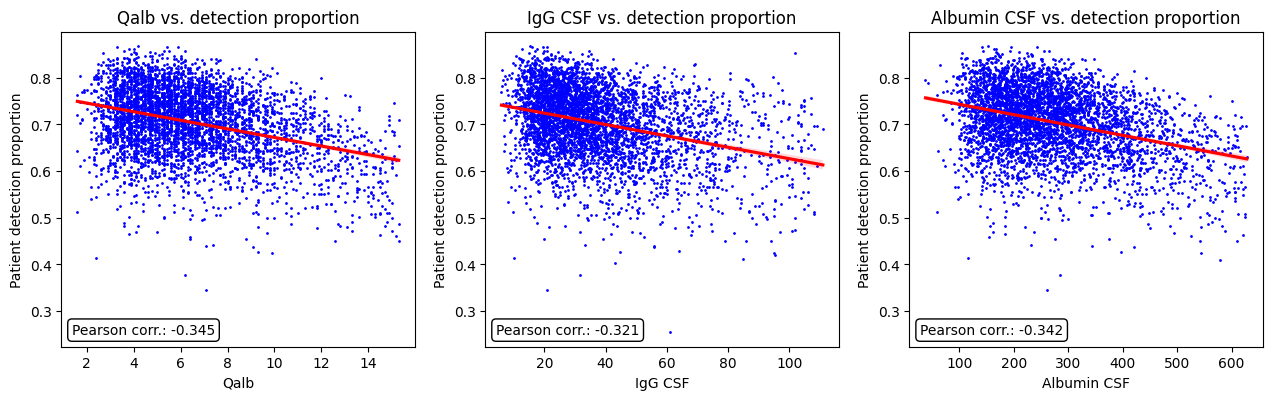

In [80]:
biomarkers = ["Qalb", "IgG CSF", "Albumin CSF"]
n_cols = len(biomarkers)

x_main = adata.layers["main"]
p_patient = np.sum(~np.isnan(x_main), axis=1) / x_main.shape[1]

fig, axes = plt.subplots(ncols=n_cols, nrows=1, figsize=(13, 4))
fig.tight_layout(pad=2.0)

for i, biomarker in enumerate(biomarkers):
    quantile_filter = adata.obs[biomarker] < adata.obs[biomarker].quantile(0.95)
    biomarker_sub = adata[quantile_filter, :].obs[biomarker]
    p_patient_sub = p_patient[quantile_filter]

    ax = axes[i]
    pearson_corr, _ = pearsonr(biomarker_sub, p_patient[quantile_filter])
    ax.text(0.03, 0.04, f"Pearson corr.: {pearson_corr:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)
    ax.scatter(x=biomarker_sub, y=p_patient_sub, color="blue", alpha=1, s=1)
    sns.regplot(x=biomarker_sub, y=p_patient_sub, ax=ax, scatter=False, color="red")
    
    ax.set_xlabel(biomarker)
    ax.set_ylabel("Patient detection proportion")
    ax.set_title(f"{biomarker} vs. detection proportion")


This is correlation is not surprising as these biomarkers are related to the blood–cerebrospinal fluid barrier - a thin barrier may lead to "contamination" of the CSF with blood cells.

Let's explore whether Qalb has an impact on protein intensity and protein detection proportion.

/tmp/ipykernel_7764/1262260580.py:25: RuntimeWarning: Mean of empty slice
  x_obs_protein = np.nanmean(adata_sub.layers["main"], axis=0)


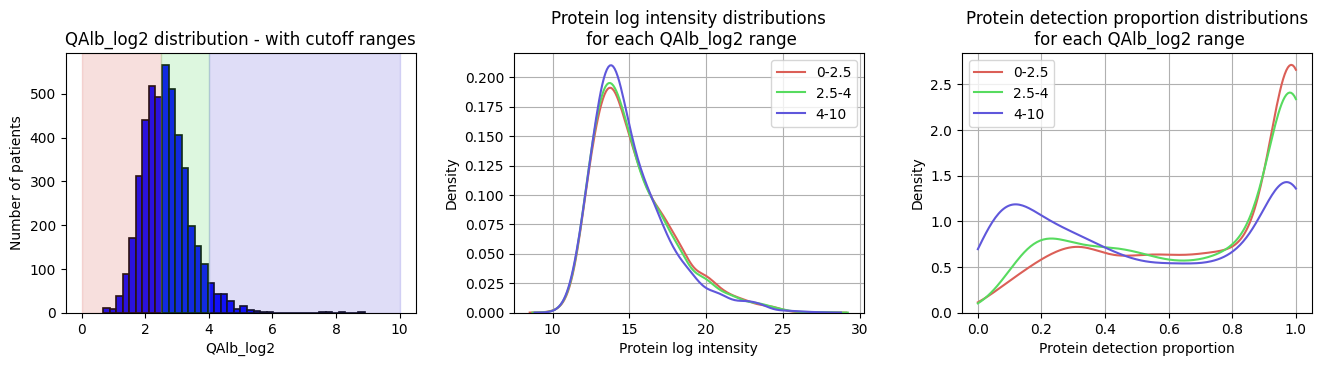

In [104]:
continous_category = "QAlb_log2"
ranges = [0, 2.5, 4, 10] # a-b, b-c, ...

fig, axes = plt.subplots(figsize=(14, 4), ncols=3)
fig.tight_layout(pad=4.0)

colors = sns.color_palette("hls", len(ranges) - 1)
adata.obs[f"{continous_category}_categorized"] = pd.cut(adata.obs[f"{continous_category}"], bins=ranges, labels=[f"{ranges[i]}-{ranges[i+1]}" for i in range(len(ranges)-1)])

ax = axes[0]
ax.hist(adata.obs[f"{continous_category}"], bins=40, color="blue", edgecolor="black", linewidth=1.2)
for i in range(1, len(ranges)):
    ax.axvspan(ranges[i-1], ranges[i], alpha=0.2, color=colors[i-1])

ax.set_xlabel(f"{continous_category}")
ax.set_ylabel("Number of patients")
ax.set_title(f"{continous_category} distribution - with cutoff ranges")

ax = axes[1]
categories = adata.obs[f"{continous_category}_categorized"].unique()
categories = categories[~pd.isnull(categories)]

for i, category in enumerate(categories):
    adata_sub = adata[adata.obs[f"{continous_category}_categorized"] == category, :]
    x_obs_protein = np.nanmean(adata_sub.layers["main"], axis=0)
    sns.kdeplot(x_obs_protein, label=category, ax=ax, color=colors[i])

ax.set_xlabel("Protein log intensity")
ax.set_ylabel("Density")
ax.set_title(f"Protein log intensity distributions\n for each {continous_category} range")
ax.legend()
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
for i, category in enumerate(categories):
    adata_sub = adata[adata.obs[f"{continous_category}_categorized"] == category, :]
    p_protein = 1 - np.mean(np.isnan(adata_sub.layers["main"]), axis=0)

    sns.kdeplot(p_protein, label=category, ax=ax, color=colors[i], clip=(0, 1))

ax.set_xlabel("Protein detection proportion")
ax.set_ylabel("Density")
ax.set_title(f"Protein detection proportion distributions\n for each {continous_category} range")
ax.grid(True)
ax.set_axisbelow(True)
ax.legend()

Let's look at intensities distribution for different categories.

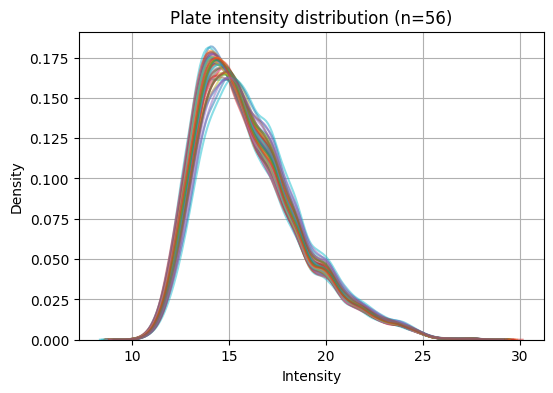

In [91]:
category = "Plate"
categories = adata.obs[category].unique()

fig, ax = plt.subplots(figsize=(6, 4))

for i, cat in enumerate(categories):
    subset = adata[adata.obs[category] == cat, :]
    x_subset = subset.layers["main"]
    x_obs_protein = x_subset[~np.isnan(x_subset)]

    sns.kdeplot(x_obs_protein, label=cat, shade=False, shade_lowest=False, ax=ax, alpha=0.5)

ax.set_xlabel("Intensity")
ax.set_ylabel("Density")
ax.set_title(f"{category} intensity distribution (n={len(categories)})")
ax.grid(True)
ax.set_axisbelow(True)

Let"s look at the distribution of the protein features.

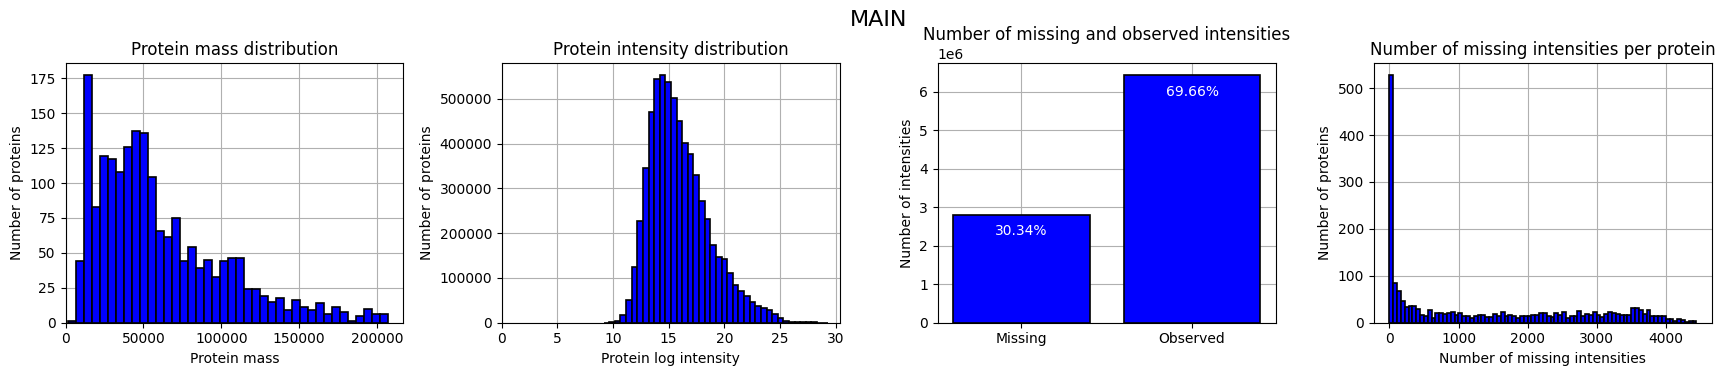

In [22]:
x_main = adata.layers["main"]

fig, axes = plt.subplots(figsize=(18, 4), nrows=1, ncols=4)
fig.tight_layout(pad=4.0)
fig.suptitle("MAIN", fontsize=16)

ax = axes[0]
biomarker_sub = adata[:, adata.var["Mass"] < adata.var["Mass"].quantile(0.95)]
ax.hist(biomarker_sub.var["Mass"], bins=40, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Protein mass")
ax.set_ylabel("Number of proteins")
ax.set_title("Protein mass distribution")
ax.set_xlim([0, None])
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
x_overlap = x_main[~np.isnan(x_main)]
ax.hist(x_overlap, bins=40, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Protein log intensity")
ax.set_ylabel("Number of proteins")
ax.set_title("Protein intensity distribution")
ax.set_xlim([0, None])
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
n_miss = np.isnan(x_main).sum()
n_obs = (~np.isnan(x_main)).sum()
n_total = n_miss + n_obs
ax.bar(["Missing", "Observed"], [n_miss, n_obs], color="blue", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of intensities")
ax.set_title("Number of missing and observed intensities")
ax.grid(True)
ax.set_axisbelow(True)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 6e5, f"{height / n_total* 100:.2f}%", ha="center", va="bottom", color="white")


ax = axes[3]
m_mask = np.isnan(x_main)
m_protein = np.sum(m_mask, axis=0)
ax.hist(m_protein, bins=80, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Number of missing intensities")
ax.set_ylabel("Number of proteins")
ax.set_title("Number of missing intensities per protein")
ax.grid(True)
ax.set_axisbelow(True)

Let's look at at detection probabilities given the avg. intensity for each protein.

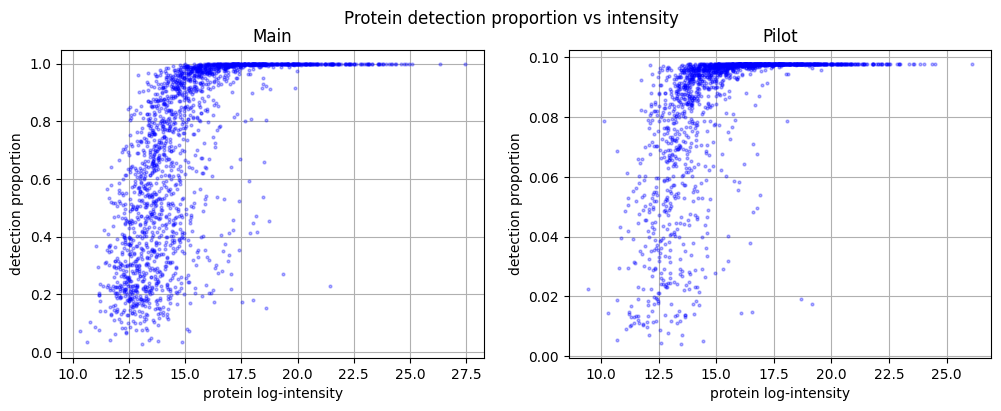

In [103]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
fig.suptitle("Protein detection proportion vs intensity")

pl.scatter_protein_detection_proportion_and_intensity(adata.layers["main"], title="Main", ax=axes[0])
pl.scatter_protein_detection_proportion_and_intensity(adata.layers["pilot"], title="Pilot", ax=axes[1])